### 1. Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mlxtend.evaluate import bias_variance_decomp
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

### 2. Data Ingestion

In [2]:
simd=pd.read_csv('../data/combined_dataset_cleaned.csv')

In [3]:
simd.head()

,Unnamed: 0,Data_Zone,Intermediate_Zone,Council_area,Total_population,Working_age_population_revised,Income_rate,Income_count,Employment_rate,Employment_count,...,PT_GP,PT_Post,PT_retail,crime_count,crime_rate,overcrowded_count,nocentralheat_count,overcrowded_rate,nocentralheat_rate,year
0,0,S01006506,Culter,Aberdeen City,904.0,605.0,0.07,60.0,0.07,40.0,...,8.437832,5.987087,5.711433,8.00642939150402,88.5666968086728,87.0,10.0,0.102113,0.011737,2016
1,1,S01006507,Culter,Aberdeen City,830.0,491.0,0.07,60.0,0.05,25.0,...,8.331833,7.262817,6.794300,4.00321469575201,48.2315023584579,85.0,4.0,0.101675,0.004785,2016
2,2,S01006508,Culter,Aberdeen City,694.0,519.0,0.05,30.0,0.03,15.0,...,7.853631,5.827924,5.251454,4.00321469575201,57.6832088725073,31.0,8.0,0.048212,0.012442,2016
3,3,S01006509,Culter,Aberdeen City,573.0,354.0,0.05,30.0,0.06,20.0,...,7.434491,8.311862,8.444698,*,*,42.0,6.0,0.072414,0.010345,2016
4,4,S01006510,Culter,Aberdeen City,676.0,414.0,0.10,70.0,0.07,30.0,...,5.141013,6.627376,6.619130,12.009644087256,177.657456912071,50.0,7.0,0.086655,0.012132,2016


In [4]:
simd.columns

Index(['Unnamed: 0', 'Data_Zone', 'Intermediate_Zone', 'Council_area',
       'Total_population', 'Working_age_population_revised', 'Income_rate',
       'Income_count', 'Employment_rate', 'Employment_count', 'CIF', 'ALCOHOL',
       'DRUG', 'SMR', 'DEPRESS', 'LBWT', 'EMERG', 'Attendance', 'Attainment',
       'Noquals', 'NEET', 'HESA', 'drive_petrol', 'drive_GP', 'drive_PO',
       'drive_primary', 'drive_retail', 'drive_secondary', 'PT_GP', 'PT_Post',
       'PT_retail', 'crime_count', 'crime_rate', 'overcrowded_count',
       'nocentralheat_count', 'overcrowded_rate', 'nocentralheat_rate',
       'year'],
      dtype='object')

### 3. Filter Numeric Columns to build correlation matrix

In [5]:
numeric_columns = simd.select_dtypes(include=['int', 'float']).columns.tolist()
numeric_columns

['Unnamed: 0',
 'Total_population',
 'Working_age_population_revised',
 'Income_rate',
 'Income_count',
 'Employment_rate',
 'Employment_count',
 'ALCOHOL',
 'DRUG',
 'SMR',
 'EMERG',
 'Noquals',
 'NEET',
 'drive_petrol',
 'drive_GP',
 'drive_PO',
 'drive_primary',
 'drive_retail',
 'drive_secondary',
 'PT_GP',
 'PT_Post',
 'PT_retail',
 'overcrowded_count',
 'nocentralheat_count',
 'overcrowded_rate',
 'nocentralheat_rate',
 'year']

In [6]:
simd[numeric_columns].describe()

,Unnamed: 0,Total_population,Working_age_population_revised,Income_rate,Income_count,Employment_rate,Employment_count,ALCOHOL,DRUG,SMR,...,drive_retail,drive_secondary,PT_GP,PT_Post,PT_retail,overcrowded_count,nocentralheat_count,overcrowded_rate,nocentralheat_rate,year
count,8042.000000,8042.000000,8042.000000,8040.000000,8042.000000,8040.000000,8042.000000,8042.000000,8042.000000,8042.000000,...,8042.000000,8042.000000,8042.000000,8042.000000,8042.000000,8042.000000,8042.000000,8042.000000,8042.000000,8042.000000
mean,4020.500000,773.620617,500.776424,0.121623,92.655558,0.105061,51.381870,99.330153,95.947311,98.990301,...,5.081690,5.945417,10.046098,8.469875,13.102799,83.870057,13.766600,0.111320,0.018261,2016.530216
std,2321.669765,200.509331,163.736946,0.095424,75.261552,0.079730,41.238569,99.790209,147.090533,45.677567,...,5.765077,4.896820,5.942590,4.386443,10.127055,65.128254,17.783708,0.079961,0.022527,1.356453
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.685475,1.017791,1.601271,1.930570,1.835432,0.000000,0.000000,0.000000,0.000000,2016.000000
25%,2010.250000,638.000000,400.000000,0.050000,35.000000,0.040000,20.000000,32.799203,0.000000,70.000000,...,2.777500,3.628994,6.267574,5.568977,7.823843,36.000000,3.000000,0.050000,0.004283,2016.000000
50%,4020.500000,758.000000,479.000000,0.100000,70.000000,0.080000,40.000000,70.165935,43.320199,92.000000,...,3.946242,4.776938,8.665514,7.465039,10.969180,68.000000,8.000000,0.093750,0.010345,2016.000000
75%,6030.750000,884.000000,569.000000,0.180000,130.000000,0.150000,70.000000,133.146010,129.245471,120.000000,...,5.730346,6.531299,12.007307,10.139799,15.499208,114.000000,17.000000,0.152297,0.023510,2016.000000
max,8041.000000,3847.000000,3423.000000,0.730000,555.000000,0.530000,325.000000,2350.544008,1864.126199,950.000000,...,190.000000,116.149193,108.789987,40.277934,190.000000,490.000000,187.000000,0.583882,0.214964,2020.000000


In [7]:
correlation_matrix = simd[numeric_columns].corr()
correlation=correlation_matrix[correlation_matrix > 0.5].fillna(0)
pd.set_option('display.max_columns', None)
correlation

,Unnamed: 0,Total_population,Working_age_population_revised,Income_rate,Income_count,Employment_rate,Employment_count,ALCOHOL,DRUG,SMR,EMERG,Noquals,NEET,drive_petrol,drive_GP,drive_PO,drive_primary,drive_retail,drive_secondary,PT_GP,PT_Post,PT_retail,overcrowded_count,nocentralheat_count,overcrowded_rate,nocentralheat_rate,year
Unnamed: 0,1.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.587325
Total_population,0.000000,1.00000,0.91505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Working_age_population_revised,0.000000,0.91505,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Income_rate,0.000000,0.00000,0.00000,1.000000,0.937342,0.960425,0.887816,0.662814,0.602498,0.539333,0.827186,0.876271,0.682559,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.533016,0.000000,0.580562,0.000000,0.000000
Income_count,0.000000,0.00000,0.00000,0.937342,1.000000,0.894768,0.951849,0.638888,0.573193,0.523268,0.780675,0.822657,0.633859,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.623356,0.000000,0.579494,0.000000,0.000000
Employment_rate,0.000000,0.00000,0.00000,0.960425,0.894768,1.000000,0.917073,0.684009,0.623805,0.526053,0.819598,0.853998,0.694087,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.546828,0.000000,0.000000
Employment_count,0.000000,0.00000,0.00000,0.887816,0.951849,0.917073,1.000000,0.672955,0.599873,0.517058,0.760625,0.778843,0.641757,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.645925,0.000000,0.602425,0.000000,0.000000
ALCOHOL,0.000000,0.00000,0.00000,0.662814,0.638888,0.684009,0.672955,1.000000,0.564774,0.000000,0.676842,0.569467,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DRUG,0.000000,0.00000,0.00000,0.602498,0.573193,0.623805,0.599873,0.564774,1.000000,0.000000,0.544279,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SMR,0.000000,0.00000,0.00000,0.539333,0.523268,0.526053,0.517058,0.000000,0.000000,1.000000,0.551405,0.523992,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### 4. Filter pairs of numeric columns that have a correlation value of greater than 0.5

In [8]:
final_dict={numeric_columns[i]+" "+numeric_columns[j]:correlation_matrix.iloc[i,j] for j in range(0,correlation_matrix.shape[1]) for i in range(0,correlation_matrix.shape[0]) if(correlation_matrix.iloc[i,j]>0.5 and correlation_matrix.iloc[i,j]!=1) }

##### This is to decide which column is to be used as our target variable

In [9]:
for i,j in final_dict.items():
    if('Employment_count' in i):
        print(i)
        print(j)
        print("***********")

Employment_count Income_rate
0.887815947474351
***********
Employment_count Income_count
0.9518493692722477
***********
Employment_count Employment_rate
0.9170730384698288
***********
Income_rate Employment_count
0.887815947474351
***********
Income_count Employment_count
0.9518493692722477
***********
Employment_rate Employment_count
0.9170730384698288
***********
ALCOHOL Employment_count
0.672955003903953
***********
DRUG Employment_count
0.5998725638904423
***********
SMR Employment_count
0.5170577167227455
***********
EMERG Employment_count
0.7606247542539755
***********
Noquals Employment_count
0.7788434307803658
***********
NEET Employment_count
0.6417568116347189
***********
overcrowded_count Employment_count
0.6459250880939955
***********
overcrowded_rate Employment_count
0.602425266084049
***********
Employment_count ALCOHOL
0.672955003903953
***********
Employment_count DRUG
0.5998725638904423
***********
Employment_count SMR
0.5170577167227455
***********
Employment_count EM

#### Employment_count has pretty good correlation values with a good number of features in the dataset.

### 5. Checking range of values for Employment_count to bin them

In [10]:
sorted(simd['Employment_count'].unique())
#0-110,120-230,240-340

[0.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 90.0,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 110.0,
 111.0,
 112.0,
 113.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 130.0,
 131.0,
 135.0,
 137.0,
 138.0,
 140.0,
 143.0,
 144.0,
 145.0,
 149.0,
 150.0,
 155.0,
 160.0,
 165.0,
 170.0,
 17

### 6. Applying binning to Employment count to make it categorical data( our new target variable)

In [11]:
trial=simd.copy()
trial['Employment_count']=trial['Employment_count'].apply(lambda x: 0 if (x >= 0 and x <= 50) else 1 if (x >= 51 and x <= 120) else 2 if x > 120 else None)

In [12]:
trial['Employment_count'].value_counts()

0    4923
1    2574
2     545
Name: Employment_count, dtype: int64

In [13]:
trial.drop('Unnamed: 0',axis=1,inplace=True)

### 7. Building a decisionTree class with helper functions to facilitate creating multiple decision trees and view evaluation metrics

In [14]:
class decisionTree:
    def __init__(self, X_train, y_train,existing_model=DecisionTreeClassifier()):
        self.model = self.fitDecisionTree(X_train, y_train,existing_model)

    def fitDecisionTree(self, X_train, y_train,new_model):
        new_model.fit(X_train, y_train)
        return new_model
    
    def predict(self,X_test):
        return self.model.predict(X_test)

    def classification_result(self, y_predict, y_test):
        report = classification_report(y_predict, y_test, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        return report_df

    def bias_variance_error(self,X_train,y_train,X_test, y_test):
        X_train,y_train,X_test,y_test=X_train.values,y_train.values,X_test.values,y_test.values
        avg_expected_loss, avg_bias, avg_variance = bias_variance_decomp(
        self.model, X_train, y_train, X_test, y_test, 
        loss='0-1_loss',
        random_seed=123)
        print("BIAS ERROR: ", avg_bias)
        print("VARIANCE ERROR: ", avg_variance)
        return [avg_bias,avg_variance]

    def Display_Confusion_Matrix(self, y_test, y_pred):
        cm = confusion_matrix(y_test, y_pred)
        conf_matrix = pd.DataFrame(data=cm, columns=['Predicted:0', 'Predicted:1', 'Predicted:2'],
                                   index=['Actual:0', 'Actual:1', 'Actual:2'])
        plt.figure(figsize=(8, 5))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="coolwarm")
        plt.show()

    def Confusion_Matrix_Metrics(self,y_test,y_pred, class_number):
        cm = confusion_matrix(y_test,y_pred)
        if class_number == 0:
            TP = cm[0, 0]
            FN = cm[0, 1] + cm[0, 2]
            FP = cm[1, 0] + cm[2, 0]
            TN = cm[1, 1] + cm[1, 2] + cm[2, 1] + cm[2, 2]
        elif class_number == 1:
            TP = cm[1, 1]
            FN = cm[1, 0] + cm[1, 2]
            FP = cm[0, 1] + cm[2, 1]
            TN = cm[0, 0] + cm[0, 2] + cm[2, 0] + cm[2, 2]
        elif class_number == 2:
            TP = cm[2, 2]
            FN = cm[2, 0] + cm[2, 1]
            FP = cm[0, 2] + cm[1, 2]
            TN = cm[0, 0] + cm[1, 1] + cm[1, 0] + cm[0, 1]
        else:
            raise ValueError("Invalid Class number")

        sensitivity = TP / float(TP + FN)
        specificity = TN / float(TN + FP)
        print('Sensitivity or True Positive Rate = TP / (TP+FN) = ', sensitivity, '\n\n',
              'Specificity or True Negative Rate = TN / (TN+FP) = ', specificity, '\n\n',
              'Positive Predictive value = TP / (TP+FP) = ', TP / float(TP + FP), '\n\n',
              'Negative predictive Value = TN / (TN+FN) = ', TN / float(TN + FN), '\n\n',
              'Positive Likelihood Ratio = Sensitivity / (1-Specificity) = ', sensitivity / (1 - specificity), '\n\n',
              'Negative likelihood Ratio = (1-Sensitivity) / Specificity = ', (1 - sensitivity) / specificity)


### 8. Building the base model (using all features)

In [15]:
X = trial.drop('Employment_count', axis=1)
y = trial['Employment_count']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=101)
X_validation,X_test,y_validation,y_test=train_test_split(X_temp,y_temp,test_size=0.5,random_state=20)

##### Label encoding categorical data 

In [16]:
encoder = LabelEncoder()
for column in X_train.columns:
    if X_train[column].dtype == 'object' :
        X_train[column] = encoder.fit_transform(X_train[column])
    if X_test[column].dtype=='object':
        X_test[column] = encoder.fit_transform(X_test[column])
    if X_validation[column].dtype == 'object':
        X_validation[column] = encoder.fit_transform(X_validation[column])


#### Making base model predictions and displaying evaluation metrics

In [17]:
base_model=decisionTree(X_train,y_train)
base_predictions=base_model.predict(X_test)

In [18]:
base_model.classification_result(base_predictions,y_test)

,precision,recall,f1-score,support
0,0.967936,0.970854,0.969393,995.000000
1,0.925926,0.908222,0.916988,523.000000
2,0.836735,0.901099,0.867725,91.000000
accuracy,0.946551,0.946551,0.946551,0.946551
macro avg,0.910199,0.926725,0.918035,1609.000000
weighted avg,0.946860,0.946551,0.946609,1609.000000


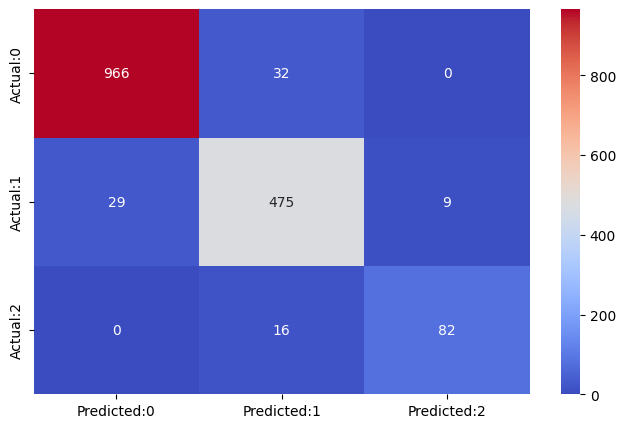

In [19]:
base_model.Display_Confusion_Matrix(y_test,base_predictions)

FOR CLASS 0

In [20]:
base_model.Confusion_Matrix_Metrics(y_test,base_predictions,0)

Sensitivity or True Positive Rate = TP / (TP+FN) =  0.9679358717434869 

 Specificity or True Negative Rate = TN / (TN+FP) =  0.9525368248772504 

 Positive Predictive value = TP / (TP+FP) =  0.9708542713567839 

 Negative predictive Value = TN / (TN+FN) =  0.9478827361563518 

 Positive Likelihood Ratio = Sensitivity / (1-Specificity) =  20.393407504664516 

 Negative likelihood Ratio = (1-Sensitivity) / Specificity =  0.033661825368950994


FOR CLASS 1

In [21]:
base_model.Confusion_Matrix_Metrics(y_test,base_predictions,1)

Sensitivity or True Positive Rate = TP / (TP+FN) =  0.9259259259259259 

 Specificity or True Negative Rate = TN / (TN+FP) =  0.9562043795620438 

 Positive Predictive value = TP / (TP+FP) =  0.9082217973231358 

 Negative predictive Value = TN / (TN+FN) =  0.9650092081031307 

 Positive Likelihood Ratio = Sensitivity / (1-Specificity) =  21.141975308642 

 Negative likelihood Ratio = (1-Sensitivity) / Specificity =  0.07746677975685608


FOR CLASS 2

In [22]:
base_model.Confusion_Matrix_Metrics(y_test,base_predictions,2)

Sensitivity or True Positive Rate = TP / (TP+FN) =  0.8367346938775511 

 Specificity or True Negative Rate = TN / (TN+FP) =  0.9940436796823295 

 Positive Predictive value = TP / (TP+FP) =  0.9010989010989011 

 Negative predictive Value = TN / (TN+FN) =  0.9894598155467721 

 Positive Likelihood Ratio = Sensitivity / (1-Specificity) =  140.4784580498856 

 Negative likelihood Ratio = (1-Sensitivity) / Specificity =  0.16424359357591237


In [23]:
X_train.shape

(4825, 36)

### 9. Apply Feature Selection Technique to improve accuracy

#### Let us use RFE(Recursive Feature Elimination) where we give a threshold on the number of top features to select for our Machine Learning Model

In [24]:
estimator = DecisionTreeClassifier(random_state=42)
selector = RFE(estimator, n_features_to_select=15, step=1)
selector = selector.fit(X_train.fillna(0), y_train)
features_rank = pd.DataFrame({'Feature':X_train.columns,'Rank':selector.ranking_})
features_rank.sort_values(by='Rank')

,Feature,Rank
0,Data_Zone,1
34,nocentralheat_rate,1
25,drive_secondary,1
26,PT_GP,1
30,crime_rate,1
10,DRUG,1
18,NEET,1
8,CIF,1
9,ALCOHOL,1
6,Income_count,1


#### Modify training and test data to consider only the top features chosen by RFE

In [25]:
X_train=X_train[list(features_rank[features_rank['Rank']==1]['Feature'].values)]
X_test=X_test[list(features_rank[features_rank['Rank']==1]['Feature'].values)]

#### Make predictions on this updated model and display evaluation metrics

In [26]:
Trimmed_model=decisionTree(X_train,y_train)
Trimmed_model_predictions=Trimmed_model.predict(X_test)

In [27]:
Trimmed_model.classification_result(y_test,Trimmed_model_predictions)

,precision,recall,f1-score,support
0,0.975976,0.976954,0.976465,998.000000
1,0.936884,0.925926,0.931373,513.000000
2,0.864078,0.908163,0.885572,98.000000
accuracy,0.956495,0.956495,0.956495,0.956495
macro avg,0.925646,0.937014,0.931136,1609.000000
weighted avg,0.956697,0.956495,0.956552,1609.000000


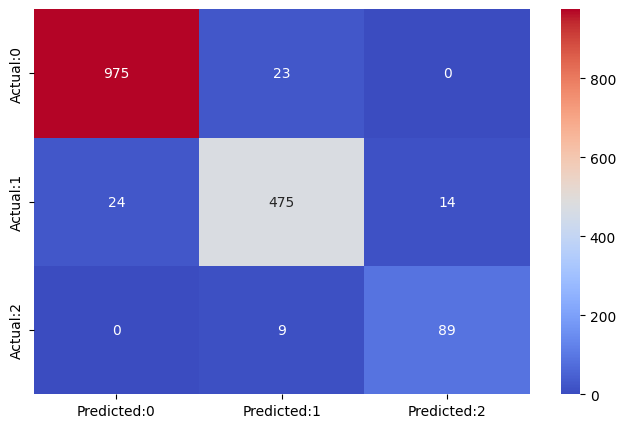

In [28]:
Trimmed_model.Display_Confusion_Matrix(y_test,Trimmed_model_predictions)

##### CLASS 0

In [29]:
Trimmed_model.Confusion_Matrix_Metrics(y_test,Trimmed_model_predictions,0)

Sensitivity or True Positive Rate = TP / (TP+FN) =  0.9769539078156313 

 Specificity or True Negative Rate = TN / (TN+FP) =  0.9607201309328969 

 Positive Predictive value = TP / (TP+FP) =  0.975975975975976 

 Negative predictive Value = TN / (TN+FN) =  0.9622950819672131 

 Positive Likelihood Ratio = Sensitivity / (1-Specificity) =  24.871618236472937 

 Negative likelihood Ratio = (1-Sensitivity) / Specificity =  0.023988351490032842


##### CLASS 1

In [30]:
Trimmed_model.Confusion_Matrix_Metrics(y_test,Trimmed_model_predictions,1)

Sensitivity or True Positive Rate = TP / (TP+FN) =  0.9259259259259259 

 Specificity or True Negative Rate = TN / (TN+FP) =  0.9708029197080292 

 Positive Predictive value = TP / (TP+FP) =  0.9368836291913215 

 Negative predictive Value = TN / (TN+FN) =  0.9655172413793104 

 Positive Likelihood Ratio = Sensitivity / (1-Specificity) =  31.712962962963 

 Negative likelihood Ratio = (1-Sensitivity) / Specificity =  0.07630186577554998


##### CLASS 2

In [31]:
Trimmed_model.Confusion_Matrix_Metrics(y_test,Trimmed_model_predictions,2)

Sensitivity or True Positive Rate = TP / (TP+FN) =  0.9081632653061225 

 Specificity or True Negative Rate = TN / (TN+FP) =  0.9907346128391793 

 Positive Predictive value = TP / (TP+FP) =  0.8640776699029126 

 Negative predictive Value = TN / (TN+FN) =  0.9940239043824701 

 Positive Likelihood Ratio = Sensitivity / (1-Specificity) =  98.01676384839591 

 Negative likelihood Ratio = (1-Sensitivity) / Specificity =  0.09269559527217701


In [32]:
bias_variance_before_pruning=Trimmed_model.bias_variance_error(X_train,y_train,X_test, y_test)

BIAS ERROR:  0.03418272218769422
VARIANCE ERROR:  0.05205717837165943


#### Our bias error is low and variance is high, which is typical for Decision Tree Models, being prone to overfitting. Considering the bias-variance trade-off, we can try to reduce the variance and slightly increase the bias

### 10.Let us use pruning, a  technique to help resolve overfitting

In [33]:
params = {'max_depth': [2,4,6,8,10,12,14,16,18,20],
         'min_samples_split': [2,3,4,5,6,7],
         'min_samples_leaf': [1,2,3,4,5]}

clf = DecisionTreeClassifier()
gcv = GridSearchCV(estimator=clf,param_grid=params)
gcv.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5, 6, 7]})

#### After getting the optimal set of hyperparameters, build the pruned decision tree and make predictions and display evaluation metrics

In [34]:
Pruned_Decision_Tree=decisionTree(X_train,y_train,gcv.best_estimator_)
Pruned_predictions=Pruned_Decision_Tree.predict(X_test)

In [35]:
Pruned_Decision_Tree.classification_result(y_test,Pruned_predictions)

,precision,recall,f1-score,support
0,0.975025,0.977956,0.976488,998.000000
1,0.935294,0.929825,0.932551,513.000000
2,0.887755,0.887755,0.887755,98.000000
accuracy,0.957116,0.957116,0.957116,0.957116
macro avg,0.932691,0.931845,0.932265,1609.000000
weighted avg,0.957042,0.957116,0.957075,1609.000000


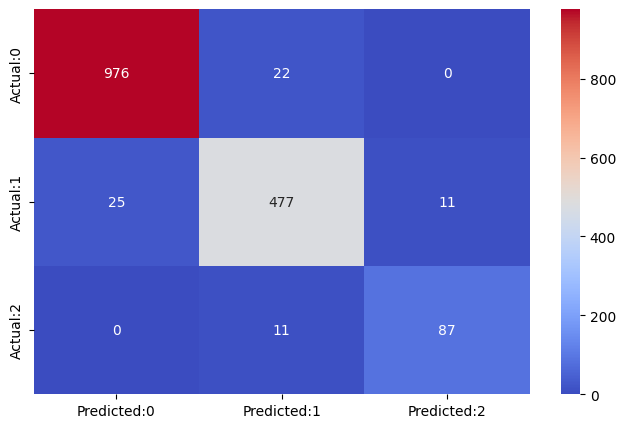

In [36]:
Pruned_Decision_Tree.Display_Confusion_Matrix(y_test,Pruned_predictions)

##### CLASS 0

In [37]:
Pruned_Decision_Tree.Confusion_Matrix_Metrics(y_test,Pruned_predictions,0)

Sensitivity or True Positive Rate = TP / (TP+FN) =  0.9779559118236473 

 Specificity or True Negative Rate = TN / (TN+FP) =  0.9590834697217676 

 Positive Predictive value = TP / (TP+FP) =  0.975024975024975 

 Negative predictive Value = TN / (TN+FN) =  0.9638157894736842 

 Positive Likelihood Ratio = Sensitivity / (1-Specificity) =  23.90124248496995 

 Negative likelihood Ratio = (1-Sensitivity) / Specificity =  0.022984535624149344


##### CLASS 1

In [38]:
Pruned_Decision_Tree.Confusion_Matrix_Metrics(y_test,Pruned_predictions,1)

Sensitivity or True Positive Rate = TP / (TP+FN) =  0.9298245614035088 

 Specificity or True Negative Rate = TN / (TN+FP) =  0.9698905109489051 

 Positive Predictive value = TP / (TP+FP) =  0.9352941176470588 

 Negative predictive Value = TN / (TN+FN) =  0.9672429481346679 

 Positive Likelihood Ratio = Sensitivity / (1-Specificity) =  30.881446039340773 

 Negative likelihood Ratio = (1-Sensitivity) / Specificity =  0.07235397996402106


##### CLASS 2

In [39]:
Pruned_Decision_Tree.Confusion_Matrix_Metrics(y_test,Pruned_predictions,2)

Sensitivity or True Positive Rate = TP / (TP+FN) =  0.8877551020408163 

 Specificity or True Negative Rate = TN / (TN+FP) =  0.9927200529450695 

 Positive Predictive value = TP / (TP+FP) =  0.8877551020408163 

 Negative predictive Value = TN / (TN+FN) =  0.9927200529450695 

 Positive Likelihood Ratio = Sensitivity / (1-Specificity) =  121.94526901669752 

 Negative likelihood Ratio = (1-Sensitivity) / Specificity =  0.11306802721088437


In [40]:
bias_variance_after_pruning=Pruned_Decision_Tree.bias_variance_error(X_train,y_train,X_test, y_test)

BIAS ERROR:  0.031696706028589185
VARIANCE ERROR:  0.047060285891858296


In [41]:
pd.DataFrame({'BIAS ERROR':[bias_variance_before_pruning[0],bias_variance_after_pruning[0]],'VARIANCE ERROR':[bias_variance_before_pruning[1],bias_variance_after_pruning[1]],'MODEL STAGE':['Before Pruning','After Pruning']})

,BIAS ERROR,VARIANCE ERROR,MODEL STAGE
0,0.034183,0.052057,Before Pruning
1,0.031697,0.047060,After Pruning


##### We can see that both our variance and bias have slightly decreased. Thus the model overfitting has been reduced by a marginal amount.

### 11. Now, let us finally test our pruned decision tree on unseen data

In [42]:
X_validation=X_validation[list(features_rank[features_rank['Rank']==1]['Feature'].values)]

In [43]:
y_pred_validation=Pruned_Decision_Tree.predict(X_validation)

c:\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [44]:
Pruned_Decision_Tree.classification_result(y_pred_validation,y_validation)

,precision,recall,f1-score,support
0,0.965243,0.976884,0.971029,995.000000
1,0.931535,0.885602,0.907988,507.000000
2,0.806723,0.905660,0.853333,106.000000
accuracy,0.943408,0.943408,0.943408,0.943408
macro avg,0.901167,0.922715,0.910783,1608.000000
weighted avg,0.944165,0.943408,0.943394,1608.000000


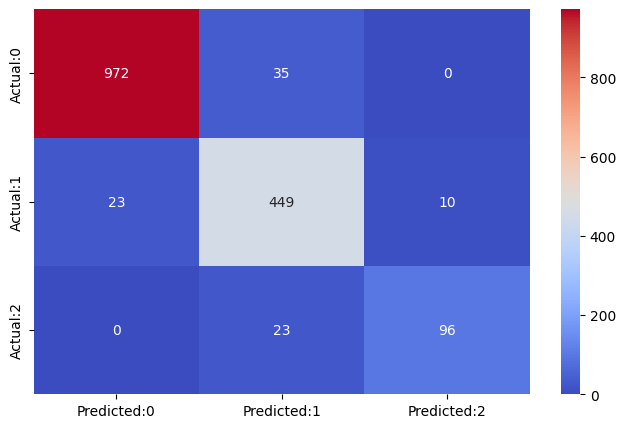

In [45]:
Pruned_Decision_Tree.Display_Confusion_Matrix(y_validation,y_pred_validation)

##### CLASS 0

In [46]:
Pruned_Decision_Tree.Confusion_Matrix_Metrics(y_validation,y_pred_validation,0)

Sensitivity or True Positive Rate = TP / (TP+FN) =  0.9652432969215492 

 Specificity or True Negative Rate = TN / (TN+FP) =  0.961730449251248 

 Positive Predictive value = TP / (TP+FP) =  0.9768844221105528 

 Negative predictive Value = TN / (TN+FN) =  0.9429037520391517 

 Positive Likelihood Ratio = Sensitivity / (1-Specificity) =  25.222227019558765 

 Negative likelihood Ratio = (1-Sensitivity) / Specificity =  0.036139755277074276


##### CLASS 1

In [47]:
Pruned_Decision_Tree.Confusion_Matrix_Metrics(y_validation,y_pred_validation,1)

Sensitivity or True Positive Rate = TP / (TP+FN) =  0.9315352697095436 

 Specificity or True Negative Rate = TN / (TN+FP) =  0.9484902309058615 

 Positive Predictive value = TP / (TP+FP) =  0.8856015779092702 

 Negative predictive Value = TN / (TN+FN) =  0.9700272479564033 

 Positive Likelihood Ratio = Sensitivity / (1-Specificity) =  18.084632994705977 

 Negative likelihood Ratio = (1-Sensitivity) / Specificity =  0.07218285234742876


##### CLASS 2

In [48]:
Pruned_Decision_Tree.Confusion_Matrix_Metrics(y_validation,y_pred_validation,2)

Sensitivity or True Positive Rate = TP / (TP+FN) =  0.8067226890756303 

 Specificity or True Negative Rate = TN / (TN+FP) =  0.9932840832773674 

 Positive Predictive value = TP / (TP+FP) =  0.9056603773584906 

 Negative predictive Value = TN / (TN+FN) =  0.9846870838881492 

 Positive Likelihood Ratio = Sensitivity / (1-Specificity) =  120.1210084033619 

 Negative likelihood Ratio = (1-Sensitivity) / Specificity =  0.1945841216811268
